In [1]:
#importujemy potrzebne biblioteki

import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, precision_score
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
#wczytanie modeli

with open('ML_ekonometria.p','rb') as fp:
    modelEkon=pickle.load(fp)
    
with open('ML_SVM.p','rb') as fp:
    modelSVM=pickle.load(fp)
    
with open('ML_kNN.p','rb') as fp:
    modelkNN=pickle.load(fp)
    
with open('ML_RF.p','rb') as fp:
    modelRF=pickle.load(fp)
    
with open('ML_XGB.p','rb') as fp:
    modelXGB=pickle.load(fp)
    
with open('ML_NN.p','rb') as fp:
    modelNN=pickle.load(fp)

In [3]:
#lista modeli

models=[]
for m in [modelEkon,modelSVM,modelkNN,modelRF,modelXGB,modelNN]:
    model=[m['specyfikacja']['df'].y,m['predykcje'],m['precyzja'],m['nazwa']]
    models.append(model)

In [4]:
models[3][3]='Random Forest'
models[4][3]='XGBoost'

In [5]:
#funkcja tworzaca wykresy precision_recall

def Precision_recall_plot(models,ax):
    for i,model in enumerate(models):
        precision,recall,thresholds=precision_recall_curve(model[0],model[1])
        ax[i].step(recall,precision,c='blue',alpha=0.8,where='post')
        ax[i].fill_between(recall,precision,step='post',color='b',alpha=0.25)
        ax[i].set_ylim([0,1.02])
        ax[i].set_xlim([-0.01,1.01])
        ax[i].set_xlabel('Recall')
        ax[i].set_ylabel('Precision')
        ax[i].set_title('{} AP = {:.3f}'.format(model[3],model[2]))
    fig.suptitle('2-class Precision-Recall Curve')

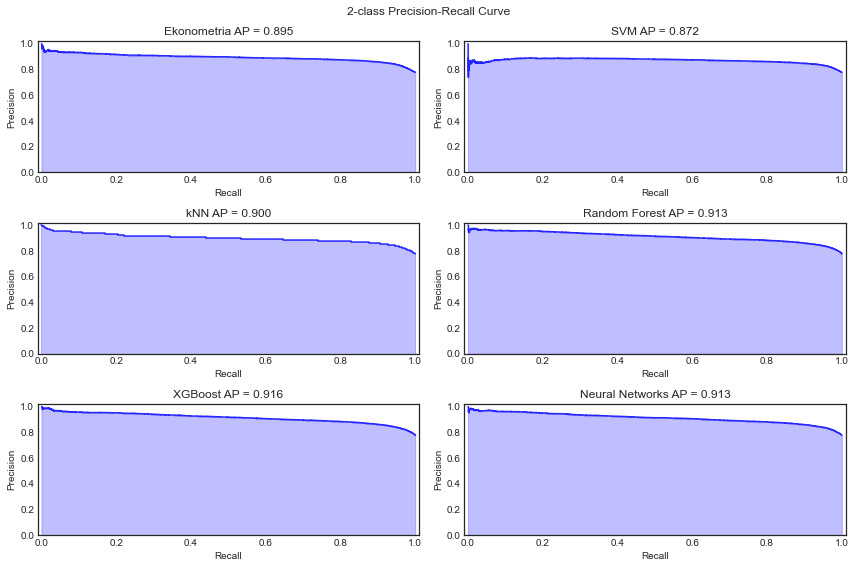

In [6]:
fig,ax=plt.subplots(3,2,figsize=(12,8))
ax=ax.flatten()
Precision_recall_plot(models,ax)
fig.tight_layout()
plt.show()

In [7]:
#najgorszy efekt dla SVM i Ekonometrii, nastepnie kNN, sieci neuronowe i Random Forest oraz XG Boost
#widac ze w najgorszym modelu roznica dotyczy glownie niskiego poziomu recall, model ten przyznaje jedne z najwyzszych wartosci niewyplacalnym osobom 

In [8]:
#funkcja rysujaca ROC

def ROC_plot(models):
    for model in models:
        RocAucScore=roc_auc_score(model[0],model[1])
        fpr,tpr,thresholds=roc_curve(model[0],model[1])
        plt.plot(fpr,tpr,c='darkorange',linewidth=2,label='{} {:.3f}'.format(model[3],RocAucScore))
    plt.plot([0,1],[0,1],linestyle='--',c='blue',linewidth=2)
    plt.legend(loc='lower right')
    plt.ylim([0,1.02])
    plt.xlim([-0.02,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic AUC ROC')
    plt.show()

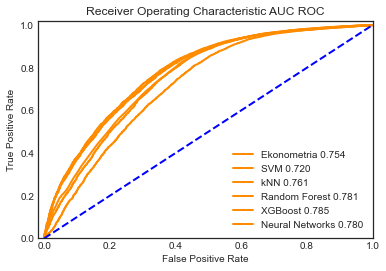

In [9]:
ROC_plot(models)

In [10]:
#biorac pod uwage te metryke, uporzadkowanie modeli nie zmienia sie
#najbardziej efektywny jest XGBoost a najmniej SVM

In [12]:
#funkcja sprawdzajaca ile wypłacalnych klientow model bedzie w stanie znalezc, 
#tak aby utrzymac precyzje na poziomie 100%

def one_hundred_percent_precision(model):
    for i,ratio in enumerate(sorted(model['predykcje'].values,reverse=True)):
        if precision_score(model['specyfikacja']['df'].y,[1 if x>=ratio else 0 for x in model['predykcje']])<1:
            print(sum(model['predykcje']>=sorted(model['predykcje'].values,reverse=True)[i-1]))
            break
    

In [13]:
#XGBoost potrafi wyznaczyc 55 pewnych klientow
one_hundred_percent_precision(modelXGB)

55


In [14]:
#SVM potrafi wyznaczyc 5 pewnych klientow
one_hundred_percent_precision(modelSVM)

5


In [15]:
#sprawdzamy indeks obserwacji, ktorej SVM przydzielil 6 najwiekszy wynik. 

ind=np.array(np.argsort(modelSVM['predykcje']))[-6]+1

#musimy dodac 1, poniewaz nasze indeksy liczone w df sa liczone od 1

In [16]:
modelSVM['specyfikacja']['df'].loc[ind]

#jak pokazala wczesniejsza analiza wykresu, SVM przypisal bardzo wysoka wartosc niewyplacalnemu klientowi

LIMIT_BAL        2.562830
AGE             -0.486615
PAY_0            0.000000
PAY_2            0.000000
PAY_3            0.000000
PAY_4            1.000000
PAY_5            2.000000
PAY_6            1.000000
BILL_AMT1       -0.458036
BILL_AMT2       -0.676919
BILL_AMT3       -0.450353
BILL_AMT4       -0.217808
BILL_AMT5       -0.332528
BILL_AMT6        0.651725
PAY_AMT1        -0.221191
PAY_AMT2        -0.039980
PAY_AMT3         1.817341
PAY_AMT4        -0.308063
PAY_AMT5         4.960293
PAY_AMT6         0.277856
y                0.000000
AGE_SQ         961.000000
PAY_0_SQ         0.000000
PAY_2_SQ         0.000000
PAY_3_SQ         0.000000
PAY_4_SQ         1.000000
PAY_5_SQ         4.000000
PAY_6_SQ         1.000000
SEX_2            1.000000
EDUCATION_1      1.000000
EDUCATION_2      0.000000
EDUCATION_3      0.000000
EDUCATION_4      0.000000
EDUCATION_5      0.000000
EDUCATION_6      0.000000
MARRIAGE_1       0.000000
MARRIAGE_2       1.000000
MARRIAGE_3       0.000000
Name: 3328, 

Podsumowanie:

Zgodnie z oczekiwaniami XGB nie był bardzo wrażliwy na zmiany hiperparametrów. Osiągał wyniki lepsze od innych algorytmów, nawet z domyślnymi parametrami. Następnymi modelami były sieci neuronowe oraz Random Forest. Nieco odbiegał od nich algorytm kNN. Najgorszymi modelami była Ekonometria oraz SVM. Kolejność modeli była identyczna przy porównywaniu precyzji oraz statystyki ROC.

Analizujac PR Curve można zobaczyć, że precyzja SVM odstaje od innych modeli głównie dla niskiego recall. Oznacza to, że wartości bliskie 1 musiało dostać względnie dużo obserwacji, dotyczących osób niespłacających zobowiązań. W przypadku XGB 55 osób, którym zostały przydzielone największe wartości, były wypłacalne. Nieefektywnosci SVM doszukuje sie w niskim rozmiarze probki wykorzystywanej do uczenia, z powodu dlugiego czasu trenowania algorytmu.  

Jedynym modelem, w którym regularyzacja poprawiła wynik był XGB. W sieciach neuronowych działał jedynie niewielki dropout. Powodem tego może być fakt, że w modelach nie była używana duża liczba zmiennych.

Dodawanie kwadratów zmiennych poprawiało modele. Musiały więc występować nieliniowe zależności. Z tego powodu sieci neuronowe RF i XGB, które dobrze radzą sobie z nieliniowością, osiągały bardzo dobre wyniki.

Najważniejszymi zmiennymi były te dotyczące wcześniejszego zalegania ze spłatami. Były najczęściej używane w RF oraz prognozy na pojedynczych zmiennych były dla nich najskuteczniejsze. Wyniki nie zmieniały się znacząco ze względu na przekształcenia zmiennych, więc możliwym uskutecznieniem predykcji byłoby zebranie większej liczby zmiennych, najlepiej tych dotyczących wcześniejszej historii kredytowej, ponieważ nawet dane dotyczące zalegania z płatnościami sprzed 6 miesięcy miały dość wysoki potencjał predykcyjny.  